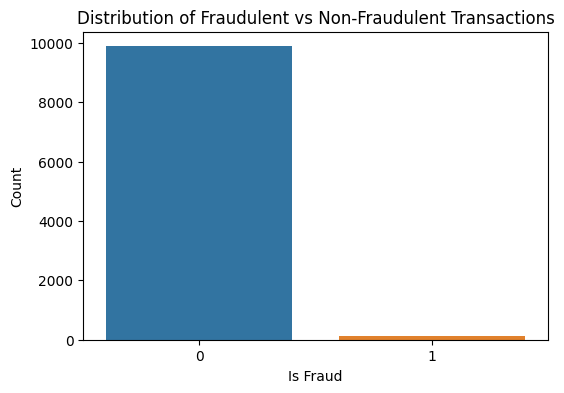

Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1975
           1       1.00      1.00      1.00        25

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



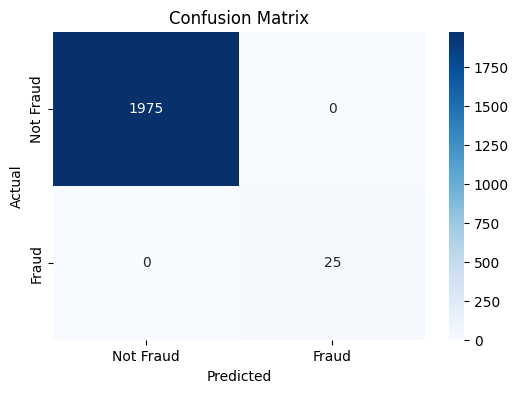

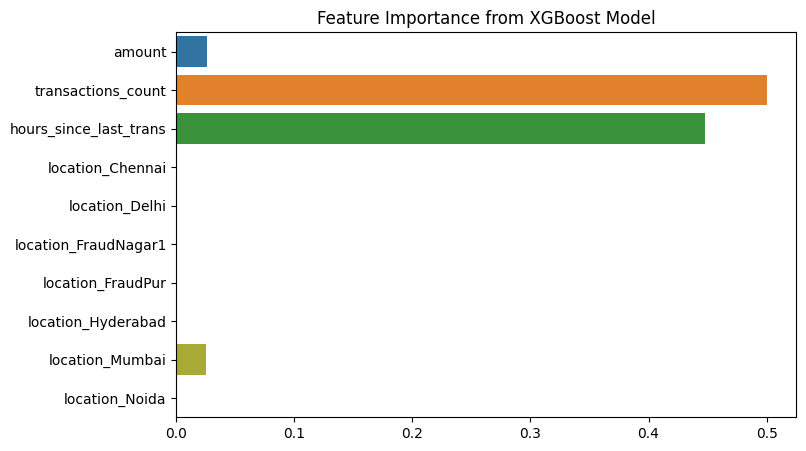

In [1]:
# E-Commerce Fraud Detection System

# Step 1: Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from xgboost import XGBClassifier

# For reproducibility
np.random.seed(42)

# Step 2: Generate synthetic transaction data
n_samples = 10000

# User IDs (simulate 2000 users)
user_ids = np.random.randint(1, 2001, size=n_samples)

# Transaction amounts: Most between 10-200, some high outliers
amounts = np.random.exponential(scale=50, size=n_samples)
amounts = np.clip(amounts, 5, 1000)

# Locations: Choose from a list of cities, some marked as suspicious
# Indian locations: mix of real and suspicious ones
locations = ['Mumbai', 'Delhi', 'Bengaluru', 'Hyderabad', 'Chennai', 'Noida', 'FraudNagar1', 'FraudPur']
location_probs = [0.25, 0.25, 0.2, 0.15, 0.1, 0.03, 0.01, 0.01]  # Fraud locations have low but non-zero probability

transaction_locations = np.random.choice(locations, size=n_samples, p=location_probs)

# Number of transactions per user (simulate 1 to 20)
trans_counts = np.random.randint(1, 21, size=n_samples)

# Time since last transaction (in hours) - normal users have longer gaps, fraudsters transact quickly
time_since_last = np.random.exponential(scale=48, size=n_samples)

# Step 3: Create a DataFrame
df = pd.DataFrame({
    'user_id': user_ids,
    'amount': amounts,
    'location': transaction_locations,
    'transactions_count': trans_counts,
    'hours_since_last_trans': time_since_last
})

# Step 4: Define fraud logic
# Business rules for fraud:
# - Transactions from suspicious locations (FakeCity1, FakeCity2)
# - High transaction amount > 300 combined with quick repeat transactions (< 1 hour)
# - Users with very high transaction counts (> 15) in short intervals

def label_fraud(row):
    if row['location'] in ['FakeCity1', 'FakeCity2']:
        return 1
    if (row['amount'] > 300) and (row['hours_since_last_trans'] < 1):
        return 1
    if (row['transactions_count'] > 15) and (row['hours_since_last_trans'] < 2):
        return 1
    return 0

df['is_fraud'] = df.apply(label_fraud, axis=1)

# Step 5: Visualize fraud distribution
plt.figure(figsize=(6,4))
sns.countplot(x='is_fraud', data=df)
plt.title('Distribution of Fraudulent vs Non-Fraudulent Transactions')
plt.xlabel('Is Fraud')
plt.ylabel('Count')
plt.show()

# Step 6: Prepare data for modeling
# Convert categorical location to numeric using one-hot encoding
df_encoded = pd.get_dummies(df, columns=['location'], drop_first=True)

# Features and target
X = df_encoded.drop(columns=['is_fraud', 'user_id'])
y = df_encoded['is_fraud']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Step 7: Train XGBoost classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# Step 8: Predictions and Evaluation
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix visualization
plt.figure(figsize=(6,4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Step 9: Visualize feature importance
plt.figure(figsize=(8,5))
sns.barplot(x=model.feature_importances_, y=X.columns)
plt.title('Feature Importance from XGBoost Model')
plt.show()
